# Stitching Data for one side of the hive (cam0 and cam1)

schauen wie viele Bienen es doppelt in beiden haelften gibt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime
from numpy.random import randn,randint
from pandas import DataFrame, Series
from bb_binary import Repository, load_frame_container
from scipy import stats

# Command so that plots appear in the iPython Notebook
%matplotlib inline

repo = Repository('../00_Data/thirdh/')

cam0 = list(repo.iter_fnames(cam=0))[0]
cam1 = list(repo.iter_fnames(cam=1))[0]
cam2 = list(repo.iter_fnames(cam=2))[0]
cam3 = list(repo.iter_fnames(cam=3))[0]

files = [cam0, cam1, cam2, cam3]

In [3]:
df = DataFrame()

# Für jede Datei die Frames einlesen und an DataFrame anhängen
for f in files:
    
    # id - ID des FrameContainers
    # frameIdx - ID von einem Frame: 0 - 1023
    # idx - ID einer Detection: kommt drauf an wie viele es so gibt
    
    fc = load_frame_container(f)
    
    for f in fc.frames:
        # alle Detections von einem Frame
        det = DataFrame([d.to_dict() for d in f.detectionsUnion.detectionsDP])
        det['frame_idx'] = f.frameIdx
        det['fc_id'] = fc.id
        det['cam_id'] = fc.camId
        det = det.set_index(['fc_id', 'frame_idx', 'idx'])
        df = pd.concat([df, det])

df.head(2)

decodedId  \
fc_id                frame_idx idx                                                      
-5179138378376356864 0         0           [0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 7, 255]   
                               1    [6, 255, 255, 255, 0, 255, 0, 255, 255, 0, 255...   

                                                                           descriptor  \
fc_id                frame_idx idx                                                      
-5179138378376356864 0         0    [216, 177, 98, 196, 137, 18, 37, 74, 149, 43, ...   
                               1    [55, 110, 221, 186, 116, 233, 210, 165, 74, 14...   

                                    localizerSaliency     radius  xRotation  \
fc_id                frame_idx idx                                            
-5179138378376356864 0         0             0.673130  23.003563  -0.005575   
                               1             0.701643  23.086124  -0.026012   

                                    xpos  xposHive  yRotation  ypos  yposHive  \
fc_id                frame_idx idx                                              
-5179138378376356864 0         0     102       102  -0.607849  1750      1750   
                               1     100       100  -0.605590  2362      2362   

                                    zRotation  cam_id  
fc_id                frame_idx idx                     
-5179138378376356864 0         0     0.010662       0  
                               1    -1.891746       0

In [4]:
df.drop(['descriptor', 'localizerSaliency', 'xposHive', 'yposHive', 'xRotation', 'yRotation'], axis=1, inplace=True)

In [5]:
df.index.names

FrozenList(['fc_id', 'frame_idx', 'idx'])

In [6]:
df.head(2)

decodedId  \
fc_id                frame_idx idx                                                      
-5179138378376356864 0         0           [0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 7, 255]   
                               1    [6, 255, 255, 255, 0, 255, 0, 255, 255, 0, 255...   

                                       radius  xpos  ypos  zRotation  cam_id  
fc_id                frame_idx idx                                            
-5179138378376356864 0         0    23.003563   102  1750   0.010662       0  
                               1    23.086124   100  2362  -1.891746       0

## Wie viele verschiedene Bienen wurden pro Kameras erkannt?
Wie groß ist die Überlappung?

### Schritte
* Ersteinmal eine lesbare ID umrechnen für alle Detections
* pro Frame Schnittmenge ausrechnen
* gucken wie groß die ist

zusammen gehoeren cam 0 und 3, 
cam 1 und 2

In [7]:
def get_binary_bit(bit, threshold):
    if (bit <= threshold):
        return 0
    
    if (bit >= 255-threshold):
        return 1
    
    else:
        return np.nan

# Zum ausrechnen der IDs
def get_detected_id(id):
    
    threshold = 50
    
    # Umrechnen in binary array [0,1,1,1,0,1,1,1,0,0,0,1]
    # Ids die nicht umgerechnet werden können, weil außerhalb des threshold, werden NAN
    binary_id = [get_binary_bit(i, threshold) for i in id]

    decimal_id = np.nan

    if not np.isnan(binary_id).any():
        # convert to decimal id using 11 least significant bits
        decimal_id = int(''.join([str(c) for c in binary_id[:11]]), 2)

        # determine what kind of parity bit was used and add 2^11 to decimal id
        # uneven parity bit was used
        if ((sum(binary_id) % 2) == 1):
            decimal_id += 2048

    return decimal_id

In [8]:
t = 10
array = df.iloc[100].decodedId
print(array)

bin = [get_binary_bit(x,t) for x in array]
bin

[208, 255, 255, 248, 255, 0, 255, 0, 255, 0, 255, 1]


[nan, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]

In [9]:
get_detected_id(array)

2005

In [10]:
df['id'] = df.decodedId.apply(get_detected_id)

**Prozent an rows die NAN enthalten**

In [11]:
rows = df.shape[0]
nulls = np.isnan(df.id).sum()
print("Total detections all cams 1024 frames: {}".format(rows))
print("{} percent NAN rows".format(nulls*100/rows))

Total detections all cams 1024 frames: 144068
19.320043312880028 percent NAN rows


In [427]:
df.head(10)

decodedId  \
fc_id                frame_idx idx                                                      
-5179138378376356864 0         0           [0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 7, 255]   
                               1    [6, 255, 255, 255, 0, 255, 0, 255, 255, 0, 255...   
                               2    [255, 0, 255, 0, 255, 255, 255, 255, 255, 0, 0...   
                               3    [218, 207, 196, 65, 162, 249, 218, 243, 158, 1...   
                               4         [0, 0, 0, 255, 0, 1, 0, 0, 254, 0, 255, 255]   
                               5         [0, 255, 0, 0, 254, 0, 0, 255, 0, 0, 255, 0]   
                               6         [0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255]   
                               7    [1, 0, 250, 254, 255, 0, 0, 253, 1, 239, 255, ...   
                               8         [0, 255, 0, 255, 0, 254, 0, 0, 0, 0, 255, 0]   
                               9    [0, 255, 0, 249, 0, 243, 255, 159, 0, 0, 253, ...   

                                       radius  xpos  ypos  zRotation  cam_id  \
fc_id                frame_idx idx                                             
-5179138378376356864 0         0    23.003563   102  1750   0.010662       0   
                               1    23.086124   100  2362  -1.891746       0   
                               2    22.594471   175  1562   0.573300       0   
                               3    23.224226   337  1050  -0.096084       0   
                               4    22.616663   388  2124   2.327337       0   
                               5    22.837029   425   812  -1.252054       0   
                               6    22.723553   449  1664   1.664661       0   
                               7    22.926441   450  2677   1.795066       0   
                               8    22.940126   476  1826  -0.389227       0   
                               9    23.274599   565  2373  -0.406192       0   

                                        id  
fc_id                frame_idx idx          
-5179138378376356864 0         0    2096.0  
                               1     941.0  
                               2    1404.0  
                               3       NaN  
                               4     133.0  
                               5     585.0  
                               6     289.0  
                               7    2507.0  
                               8     673.0  
                               9       NaN

In [12]:
df_ids = df.dropna()

In [13]:
df_ids.head(10)

decodedId  \
fc_id                frame_idx idx                                                      
-5179138378376356864 0         0           [0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 7, 255]   
                               1    [6, 255, 255, 255, 0, 255, 0, 255, 255, 0, 255...   
                               2    [255, 0, 255, 0, 255, 255, 255, 255, 255, 0, 0...   
                               4         [0, 0, 0, 255, 0, 1, 0, 0, 254, 0, 255, 255]   
                               5         [0, 255, 0, 0, 254, 0, 0, 255, 0, 0, 255, 0]   
                               6         [0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255]   
                               7    [1, 0, 250, 254, 255, 0, 0, 253, 1, 239, 255, ...   
                               8         [0, 255, 0, 255, 0, 254, 0, 0, 0, 0, 255, 0]   
                               10   [255, 0, 0, 255, 0, 255, 255, 255, 255, 0, 0, ...   
                               11   [0, 255, 255, 255, 255, 255, 0, 255, 0, 0, 255...   

                                       radius  xpos  ypos  zRotation  cam_id  \
fc_id                frame_idx idx                                             
-5179138378376356864 0         0    23.003563   102  1750   0.010662       0   
                               1    23.086124   100  2362  -1.891746       0   
                               2    22.594471   175  1562   0.573300       0   
                               4    22.616663   388  2124   2.327337       0   
                               5    22.837029   425   812  -1.252054       0   
                               6    22.723553   449  1664   1.664661       0   
                               7    22.926441   450  2677   1.795066       0   
                               8    22.940126   476  1826  -0.389227       0   
                               10   22.786806   652  1887   0.301280       0   
                               11   23.077099   712  1049  -1.764035       0   

                                        id  
fc_id                frame_idx idx          
-5179138378376356864 0         0    2096.0  
                               1     941.0  
                               2    1404.0  
                               4     133.0  
                               5     585.0  
                               6     289.0  
                               7    2507.0  
                               8     673.0  
                               10   3260.0  
                               11   1001.0

## Schauen ob pro Frame, alle Detection Ids unique sind.

In [430]:
# df.ix[:,0,:]
#f0 = df_ids.xs(0, level='frame_idx').xs(-5179138378376356864, level='fc_id')
# df.sort_index().loc[[slice(None), 0, slice(None)]]
#f0

In [14]:
df2 = df.reset_index(level=1).reset_index(level=1).reset_index(level=1)
df2 = df2.dropna()
df2.head()

,fc_id,idx,frame_idx,decodedId,radius,xpos,ypos,zRotation,cam_id,id
0,-5179138378376356864,0,0,"[0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 7, 255]",23.003563,102,1750,0.010662,0,2096.0
1,-5179138378376356864,1,0,"[6, 255, 255, 255, 0, 255, 0, 255, 255, 0, 255...",23.086124,100,2362,-1.891746,0,941.0
2,-5179138378376356864,2,0,"[255, 0, 255, 0, 255, 255, 255, 255, 255, 0, 0...",22.594471,175,1562,0.573300,0,1404.0
4,-5179138378376356864,4,0,"[0, 0, 0, 255, 0, 1, 0, 0, 254, 0, 255, 255]",22.616663,388,2124,2.327337,0,133.0
5,-5179138378376356864,5,0,"[0, 255, 0, 0, 254, 0, 0, 255, 0, 0, 255, 0]",22.837029,425,812,-1.252054,0,585.0


### In welchen Frames gibt es gleiche IDs?

In [432]:
gr = df2.groupby(['cam_id', 'frame_idx'])

id_unique = gr['id'].aggregate(lambda x: x.nunique())
id_sizes = gr['id'].size()

df_id_unique = DataFrame({'uniques': id_unique, 'sizes': id_sizes})
df_id_unique['diff'] = df_id_unique.sizes - df_id_unique.uniques
df_id_unique.head()

df_id_unique[df_id_unique['diff'] > 0]

sizes  uniques  diff
cam_id frame_idx                      
1      73            48     47.0   1.0
       113           48     47.0   1.0
       114           48     47.0   1.0
       115           49     48.0   1.0
       127           53     52.0   1.0
       249           58     57.0   1.0
       400           54     53.0   1.0
       590           58     57.0   1.0
       878           48     47.0   1.0
       959           55     54.0   1.0
       963           61     60.0   1.0
2      1             24     23.0   1.0
       5             23     22.0   1.0
       584           22     21.0   1.0
3      86            22     21.0   1.0

In [15]:
gr2 = df2.groupby(['frame_idx'])

n_uniques = gr2['id'].aggregate(lambda x: x.nunique())
n_sizes = gr2['id'].size()

In [16]:
df_counts = DataFrame({'uniques': n_uniques, 'sizes': n_sizes})
df_counts['diff'] = np.abs(df_counts.sizes - df_counts.uniques)
df_counts.head()

,sizes,uniques,diff
frame_idx,,,
0,122,114.0,8.0
1,111,103.0,8.0
2,111,105.0,6.0
3,114,106.0,8.0
4,108,100.0,8.0


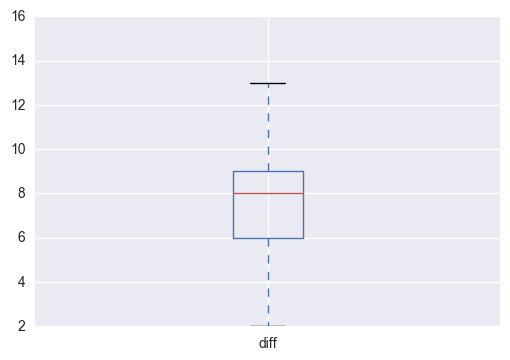

In [435]:
df_counts['diff'].plot.box()

In [436]:
df_counts['diff'].describe()

count    1024.000000
mean        7.729492
std         2.162976
min         2.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        15.000000
Name: diff, dtype: float64